# Train Model: Transfer Learning with Fine-Tunning ResNet-50 Model

- Nama: Travis Zusa Zuve Saputra
- NIM: 22537141013
- Kelas: I.1

### Import Libraries

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.models import efficientnet_b0
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

### Setting a Random Seed

In [21]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

### Device Configuration

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Data Transformations

In [23]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.GaussianBlur(kernel_size=5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Dataset Loading and Splitting

In [24]:
data_dir = '../data'
dataset = datasets.ImageFolder(data_dir, transform=train_transform)

In [25]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

from collections import Counter
class_counts = Counter([label for _, label in dataset.samples])
total_samples = len(dataset)

### Class Weights Calculation for Imbalanced Data

In [26]:
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

class_weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))]).to(device)

### Data Transformation

In [27]:
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

### Data Loaders

In [28]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Loading and Modifying a Pretrained Model

In [29]:
model = models.resnet50(pretrained=True)

d:\Kuliah\Software\Visual Studio Code\Python\Semester_5\Praktik_Aplikasi_Web\Praktikum_09\chess-classification\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Kuliah\Software\Visual Studio Code\Python\Semester_5\Praktik_Aplikasi_Web\Praktikum_09\chess-classification\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [30]:
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 6)

In [31]:
for param in model.parameters():
    param.requires_grad = True

In [32]:
model = model.to(device)

### Loss Function, Optimizer, and Learning Rate Scheduler

In [33]:
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=True)

d:\Kuliah\Software\Visual Studio Code\Python\Semester_5\Praktik_Aplikasi_Web\Praktikum_09\chess-classification\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Validate Function

In [34]:
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    accuracy = 100 * correct / total
    return val_loss / len(val_loader), accuracy

### Confusion Matrix Plotting

In [35]:
def plot_confusion_matrix(cm, class_names, epoch):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix - Epoch {epoch}")
    plt.show()

def evaluate_confusion_matrix(model, val_loader, device, class_names, epoch):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, class_names, epoch)

### Train Function and Plotting Loss or Accuracy

In [36]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=30, model_path="../model/best-model-resnet.pth"):
    best_val_loss = float('inf')
    early_stopping_counter = 0
    early_stopping_patience = 5 

    class_names = train_loader.dataset.dataset.classes

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0  
        total_train = 0 

        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch [{epoch+1}/{epochs}]")
        
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

            train_loss = running_loss / (i + 1)
            train_acc = 100 * correct_train / total_train

            progress_bar.set_postfix()

        val_loss, val_acc = validate(model, val_loader, criterion, device)
        scheduler.step(val_loss)

        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        evaluate_confusion_matrix(model, val_loader, device, class_names, epoch+1)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_path)
            print(f"Model improved, saved as {model_path} with val_loss: {val_loss:.4f}")
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print("Early stopping triggered.")
                break

    epochs_range = list(range(1, len(train_loss_history) + 1))
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))

    axes[0].plot(epochs_range, train_loss_history, label="Training")
    axes[0].plot(epochs_range, val_loss_history, label="Validation")
    axes[0].legend()
    axes[0].set_title("Loss log")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")

    axes[1].plot(epochs_range, train_acc_history, label="Training")
    axes[1].plot(epochs_range, val_acc_history, label="Validation")
    axes[1].legend()
    axes[1].set_title("Accuracy log")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy (%)")

    plt.tight_layout()
    plt.show()


### Train Function Called

Epoch [1/30]: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


Epoch [1/30], Train Loss: 1.1644, Train Acc: 56.46%, Val Loss: 92.4400, Val Acc: 21.82%


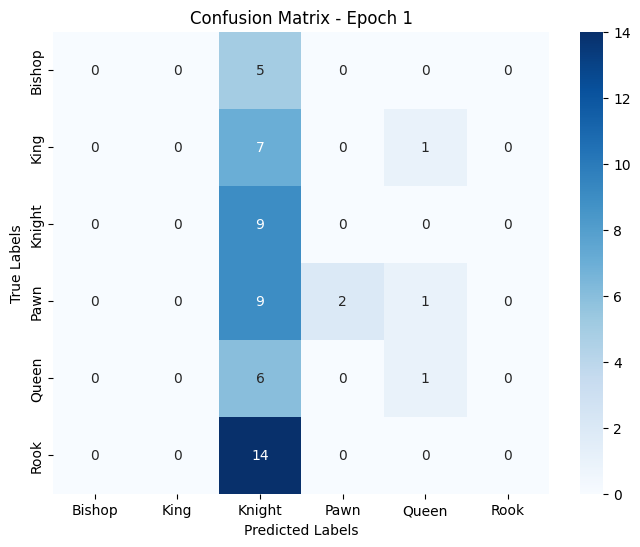

Model improved, saved as ../model/best-resnet-model.pth with val_loss: 92.4400


Epoch [2/30]: 100%|██████████| 14/14 [00:09<00:00,  1.47it/s]


Epoch [2/30], Train Loss: 0.5544, Train Acc: 83.22%, Val Loss: 1.4457, Val Acc: 65.45%


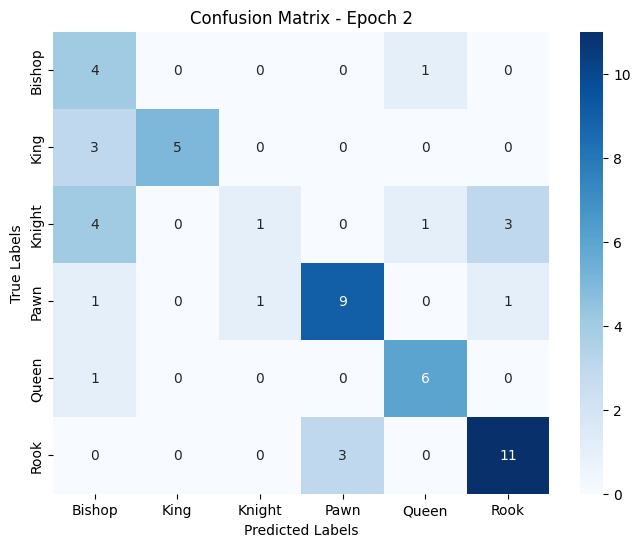

Model improved, saved as ../model/best-resnet-model.pth with val_loss: 1.4457


Epoch [3/30]: 100%|██████████| 14/14 [00:09<00:00,  1.48it/s]


Epoch [3/30], Train Loss: 0.4783, Train Acc: 85.94%, Val Loss: 3.6578, Val Acc: 52.73%


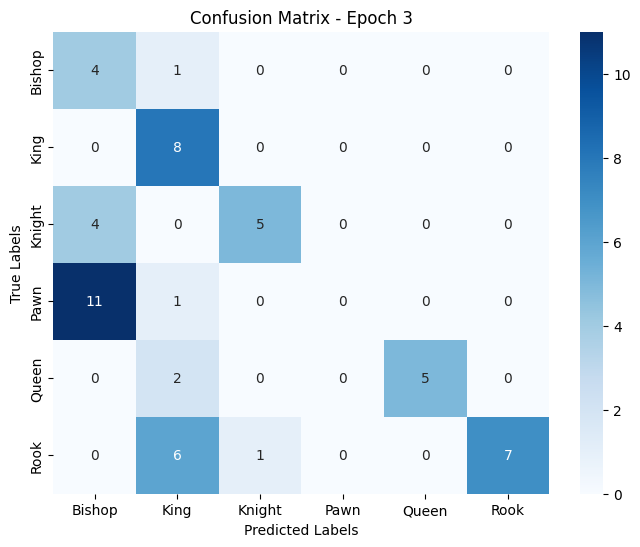

Epoch [4/30]: 100%|██████████| 14/14 [00:08<00:00,  1.59it/s]


Epoch [4/30], Train Loss: 0.2843, Train Acc: 92.52%, Val Loss: 0.7501, Val Acc: 78.18%


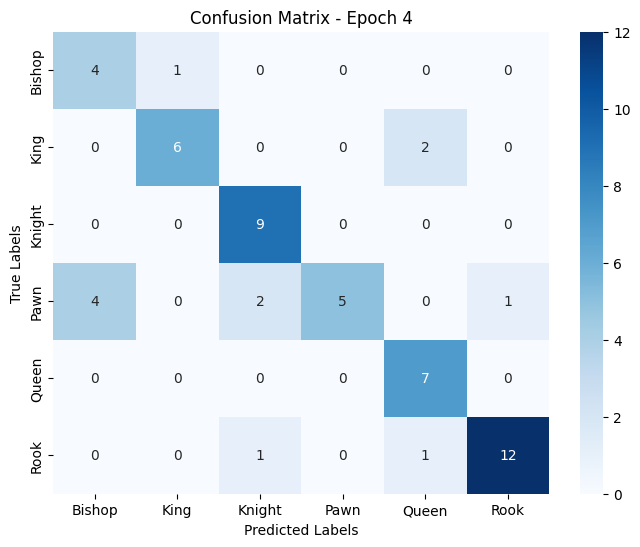

Model improved, saved as ../model/best-resnet-model.pth with val_loss: 0.7501


Epoch [5/30]: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s]


Epoch [5/30], Train Loss: 0.2057, Train Acc: 93.42%, Val Loss: 2.2167, Val Acc: 65.45%


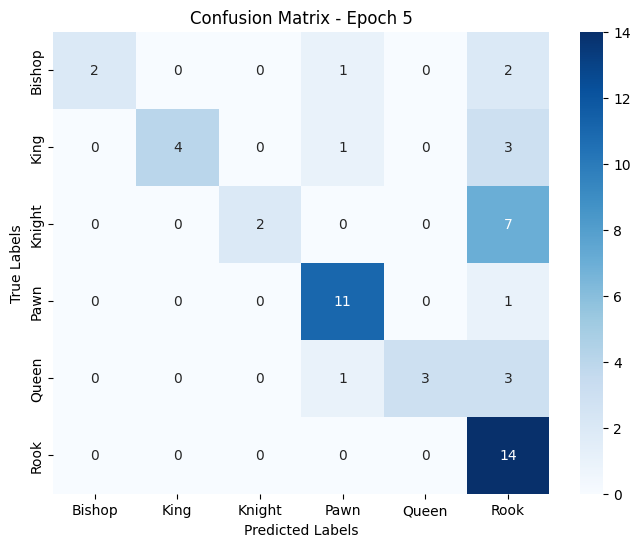

Epoch [6/30]: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s]


Epoch [6/30], Train Loss: 0.1732, Train Acc: 95.69%, Val Loss: 1.3415, Val Acc: 81.82%


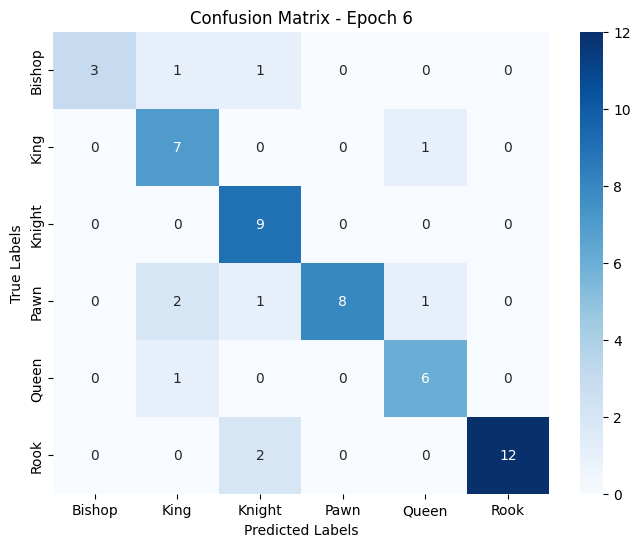

Epoch [7/30]: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s]


Epoch [7/30], Train Loss: 0.1621, Train Acc: 95.01%, Val Loss: 0.1756, Val Acc: 96.36%


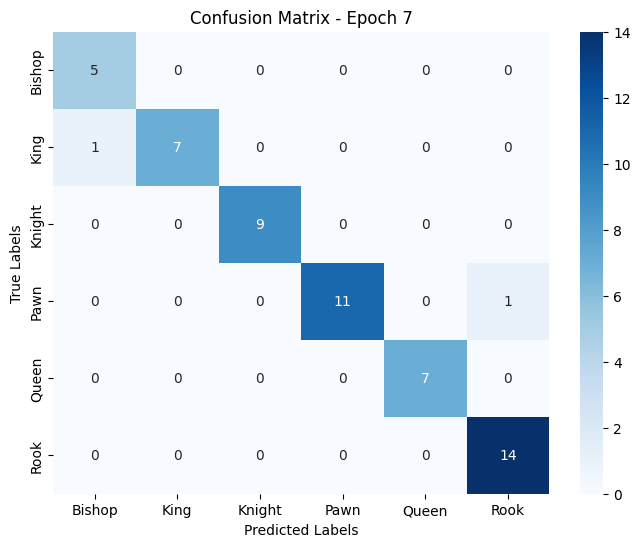

Model improved, saved as ../model/best-resnet-model.pth with val_loss: 0.1756


Epoch [8/30]: 100%|██████████| 14/14 [00:08<00:00,  1.61it/s]


Epoch [8/30], Train Loss: 0.2347, Train Acc: 91.61%, Val Loss: 1.1851, Val Acc: 69.09%


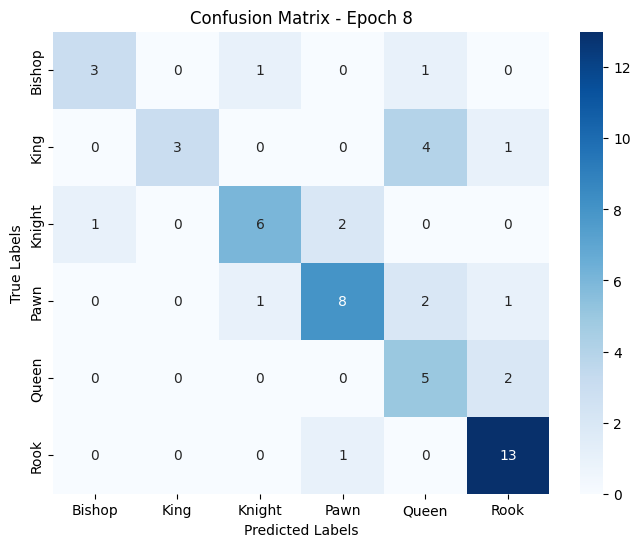

Epoch [9/30]: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s]


Epoch [9/30], Train Loss: 0.1782, Train Acc: 93.88%, Val Loss: 0.6457, Val Acc: 81.82%


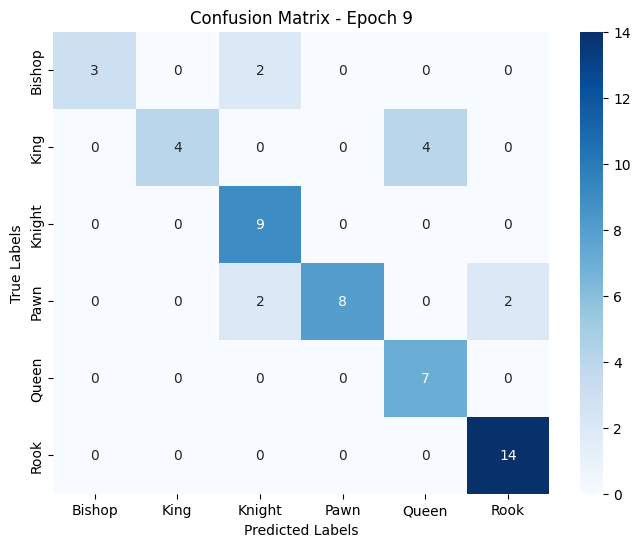

Epoch [10/30]: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s]


Epoch [10/30], Train Loss: 0.0799, Train Acc: 97.28%, Val Loss: 0.4608, Val Acc: 89.09%


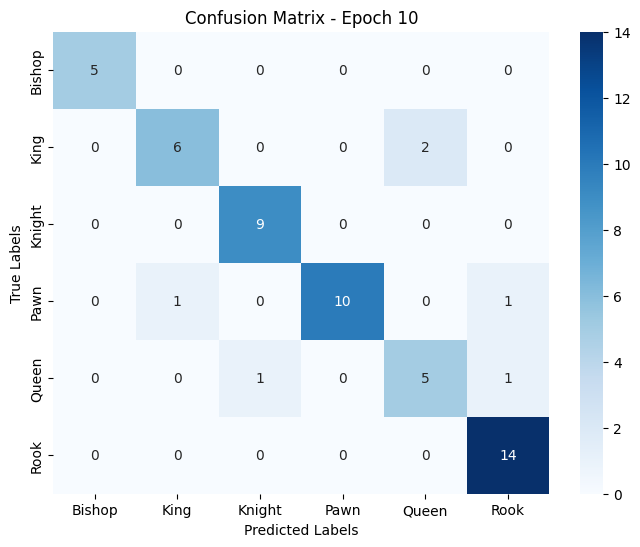

Epoch [11/30]: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s]


Epoch [11/30], Train Loss: 0.0733, Train Acc: 97.28%, Val Loss: 2.4359, Val Acc: 74.55%


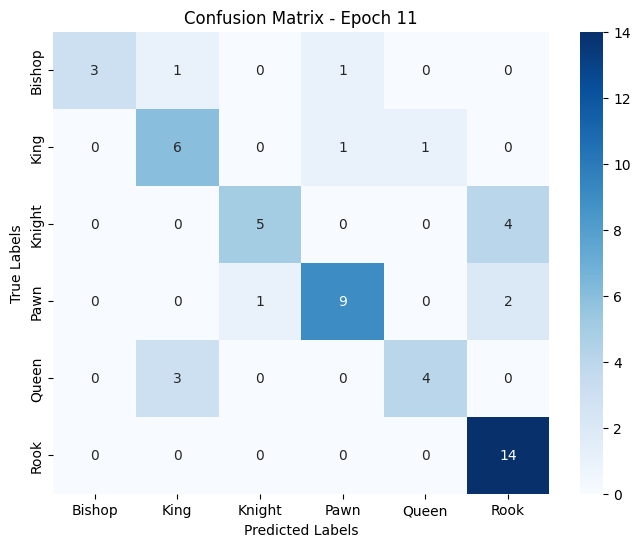

Epoch [12/30]: 100%|██████████| 14/14 [00:08<00:00,  1.61it/s]


Epoch [12/30], Train Loss: 0.1113, Train Acc: 97.28%, Val Loss: 0.2694, Val Acc: 92.73%


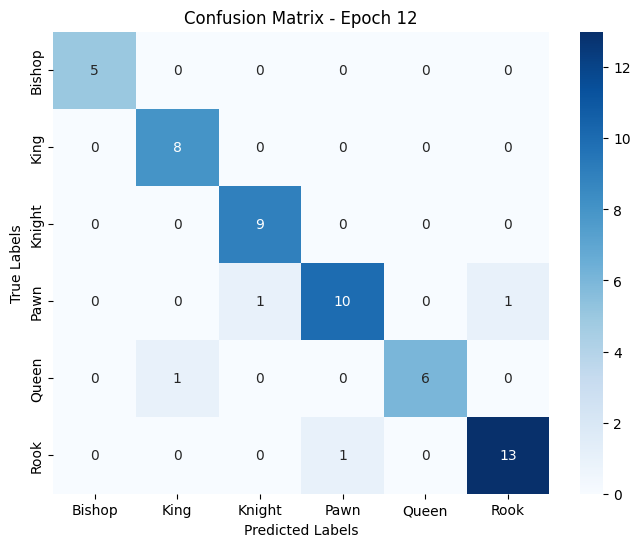

Early stopping triggered.


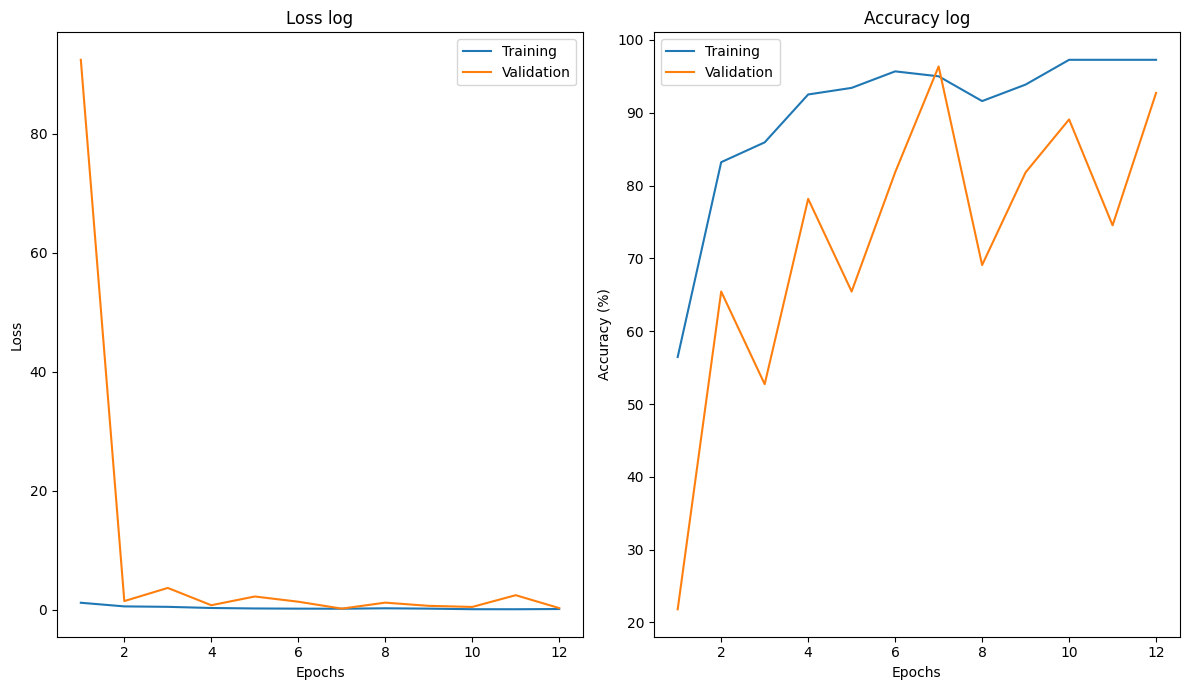

In [37]:
train(model, train_loader, val_loader, criterion, optimizer, scheduler, device)